# 6: The Haunted DAG and the Causal Terror

In [1]:
%cd "c:/msys64/home/ecotner/statistical-rethinking/"

c:\msys64\home\ecotner\statistical-rethinking


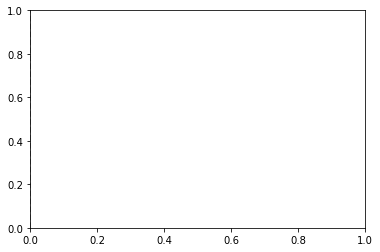

In [2]:
import sys
import time
from collections import deque

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import networkx as nx

import torch
import torch.tensor as tt
import pyro
from pyro.distributions import Normal, Uniform, Exponential, LogNormal
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

sys.path.insert(0, "c:/msys64/home/ecotner/statistical-rethinking/code")
from utils import HPDI, precis, conditional_independencies, marginal_independencies

### Code 6.1
Unfortunately due to selection bias, previously uncorrelated predictors can become falsely correlated. For example, if newsworthiness and trustworthiness of an article are weighted equally, and only the top 10% of submitted articles are accepted, there will become a negative correlation between newsworthiness and trustworthiness amongst published articles. If you don't condition on whether an article is published or not, the correlation disappears!

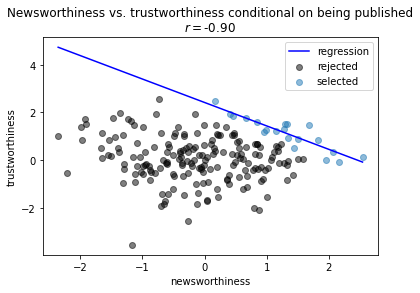

In [3]:
N = 200 # number of submitted articles
p = 0.1 # top fraction to accept
# generate uncorrelated newsworthiness/trustworthiness
nw = np.random.randn(N)
tw = np.random.randn(N)
# select top 10% of combined scores
score = nw + tw
q = np.quantile(score, 1-p)
mask = (score >= q)
# Visualize correlation
plt.scatter(nw[~mask], tw[~mask], color="black", alpha=0.5, label="rejected")
plt.scatter(nw[mask], tw[mask], color="C0", alpha=0.5, label="selected")
m, b, r, _, _ = st.linregress(nw[mask], tw[mask])
x = np.linspace(nw.min(), nw.max())
y = m*x + b
plt.plot(x, y, color="blue", label="regression")
plt.title("Newsworthiness vs. trustworthiness conditional on being published\n$r=$"f"{r:.2f}")
plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")
plt.legend()
plt.show()

### Code 6.2 - 6.6
We will explore multicollinearity by simulating an experiment where a population of various heights and leg length proportions is generated, and then a small, asymmetry between the left/right legs is also generated.

In [4]:
N = 100
height = 2*np.random.randn(N)+10
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop * height + 0.02*np.random.randn(N)
leg_right = leg_prop * height + 0.02*np.random.randn(N)
df = pd.DataFrame([height, leg_left, leg_right], index=["height", "leg_left", "leg_right"]).T
df.head()

,height,leg_left,leg_right
0,10.201479,5.021898,5.026252
1,7.729154,3.467672,3.480120
2,14.701010,6.096418,6.072396
3,10.881777,4.623465,4.592721
4,9.937173,4.843069,4.865479


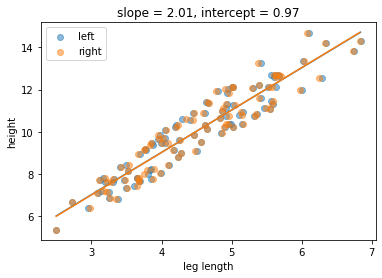

In [5]:
for side in ["left", "right"]:
    x = df[f"leg_{side}"]
    y = df["height"]
    plt.scatter(x, y, alpha=0.5, label=side)
    m, b, _, _, _ = st.linregress(x, y)
    x = np.linspace(x.min(), x.max())
    y = m * x + b
    plt.plot(x, y)
plt.title(f"slope = {m:.2f}, intercept = {b:.2f}")
plt.legend()
plt.xlabel("leg length")
plt.ylabel("height")
plt.show()

In [6]:
class LegSim:
    def __init__(self, df):
        self.height = tt(df["height"].values).double()
        self.left = tt(df["leg_left"].values).double()
        self.right = tt(df["leg_right"].values).double()
        
    def __call__(self):
        a = pyro.sample("a", Normal(*tt((10., 100.))))
        bl = pyro.sample("bl", Normal(*tt((2., 10.))))
        br = pyro.sample("br", Normal(*tt((2., 10.))))
        sigma = pyro.sample("sigma", Exponential(tt(1.)))
        mu = pyro.deterministic("mu", a + bl*self.left + br*self.right)
        pyro.sample("height", Normal(mu, sigma), obs=self.height)
        
    def train(self, num_steps):
        pyro.clear_param_store()
        # Initializing to the mean actually causes the multicollinearity to go away...
#         self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        self.guide = AutoMultivariateNormal(self)
        svi = SVI(self, guide=self.guide, optim=Adam({"lr": 1e-2}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

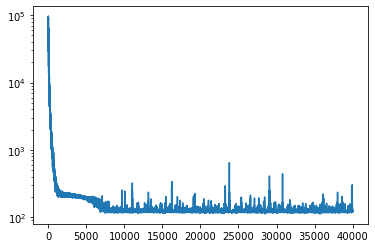

In [7]:
x = tt(df["leg_left"].values).double()
y = tt(df["height"].values).double()
m6_1 = LegSim(df)
loss = m6_1.train(40000) # takes VERY long time to train
plt.plot(loss); plt.yscale("log"); plt.show()

Let's sample from the posterior... we can see that the distributions for $bl$ and $br$ are pretty messed up; very wide HPDI. If we were to run the training again, it is very likely we would get different mean values as well.

In [8]:
def sample_posterior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            guide=model.guide,
            num_samples=num_samples,
            return_sites=sites,
        )().items()
    }

def sample_prior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            {},
            return_sites=sites,
            num_samples=num_samples
        )().items()
    }

In [9]:
samples = sample_posterior(m6_1, 1000, sites=("a", "bl", "br", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
a,0.963506,0.339031,0.4129,1.48662
bl,0.742063,0.864781,-0.602775,2.16974
br,1.2787,0.875781,-0.131322,2.65222
sigma,0.708381,0.0659505,0.608107,0.819876


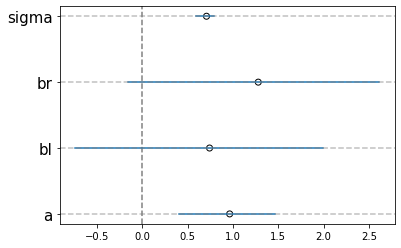

In [10]:
def plot_intervals(samples, p):
    for i, (k, s) in enumerate(samples.items()):
        mean = s.mean()
        hpdi = HPDI(s, p)
        plt.scatter([mean], [i], facecolor="none", edgecolor="black")
        plt.plot(hpdi, [i, i], color="C0")
        plt.axhline(i, color="grey", alpha=0.5, linestyle="--")
    plt.yticks(range(len(samples)), samples.keys(), fontsize=15)
plt.axvline(0, color="black", alpha=0.5, linestyle="--")
        
plot_intervals(samples, 0.89)

But the prediction turns out fine! The residuals from the mean are fairly small given how big the coefficients are. What gives? Why are the posteriors so broad, but give the right answer?

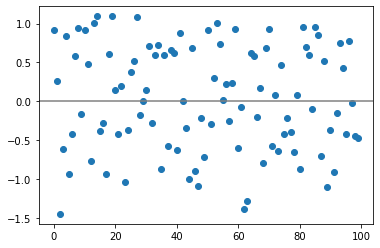

In [11]:
a = samples["a"].mean()
bl = samples["bl"].mean()
br = samples["br"].mean()
y = a + bl * df["leg_left"].values + br * df["leg_right"].values
plt.scatter(range(len(y)), y - df["height"])
plt.axhline(0, color="gray")
plt.show()

Well, it's _multicollinearity_; because the predictors leg_left and leg_right are so similar, we have $l_i \approx r_i$, and therefore
$$
h_i = a + bl * l_i + br * r_i \approx a + bl * l_i + br * l_i = a + (bl + br) * l_i
$$

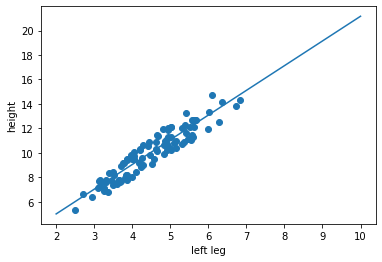

In [12]:
plt.scatter(df["leg_left"], df["height"])
a = samples["a"].mean()
bl = samples["bl"].mean()
br = samples["br"].mean()
x = np.linspace(2, 10)
y = a + (bl + br) * x
plt.plot(x, y)
plt.xlabel("left leg")
plt.ylabel("height")
plt.show()

We can see that $bl$ and $br$ are _highly_ negatively correlated with each other, which makes sense; because the sum $bl+br$ is the only thing that matters, you can increase $bl$ at the cost of decreasing $br$ - their sum remains the same.

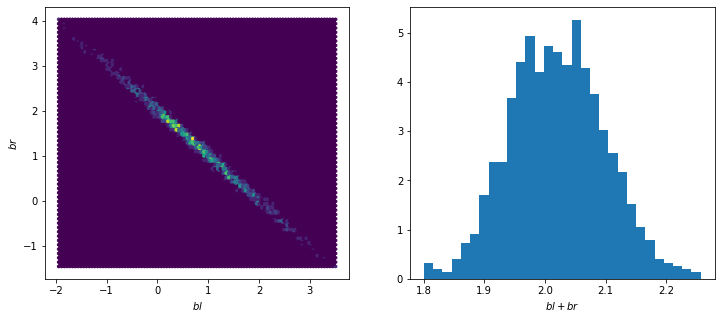

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plt.sca(axes[0])
plt.hexbin(samples["bl"], samples["br"])
plt.xlabel("$bl$")
plt.ylabel("$br$")
plt.sca(axes[1])
plt.hist(samples["bl"] + samples["br"], bins=30, density=True)
plt.xlabel("$bl + br$")
plt.show()

### Code 6.8
Look at the milk data again

In [14]:
milk_df = pd.read_csv("data/milk.csv", sep=";")
milk_df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [15]:
rename = {"kcal.per.g": "K", "perc.fat": "F", "perc.lactose": "L"}
df = milk_df[rename.keys()].rename(columns=rename)
for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()

### Code 6.9
Do simple linear regression of $K$ on $F$ and $L$ separately

In [16]:
class RegressionBase:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
            
    def __call__(self):
        raise NotImplementedError
        
    def train(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        svi = SVI(self, guide=self.guide, optim=Adam({"lr": 1e-2}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss

class M6_3(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bF = pyro.sample("bF", Normal(0, 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bF*self.F)
        pyro.sample("height", Normal(mu, sigma), obs=self.K)
        
class M6_4(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bL = pyro.sample("bL", Normal(0, 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bL*self.L)
        pyro.sample("height", Normal(mu, sigma), obs=self.K)

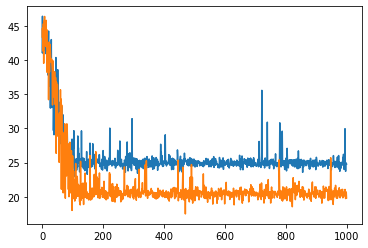

In [17]:
m6_3 = M6_3(df)
m6_4 = M6_4(df)
loss = m6_3.train(1000)
plt.plot(loss)
loss = m6_4.train(1000)
plt.plot(loss)
plt.show()

In [18]:
samples3 = sample_posterior(m6_3, 1000, ("a", "bF", "sigma"))
samples4 = sample_posterior(m6_4, 1000, ("a", "bL", "sigma"))

            mean     stddev       5.5%     94.5%
a      0.0285305  0.0693821 -0.0836324  0.142017
bF      0.879156  0.0699158   0.764029  0.985904
sigma   0.489116  0.0611805   0.399983  0.592242


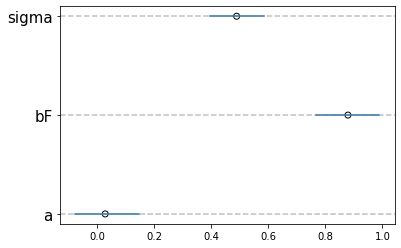

In [19]:
print(precis(samples3))
plot_intervals(samples3, 0.89)

            mean     stddev      5.5%      94.5%
a     -0.0417148  0.0714119 -0.155507  0.0761317
bL     -0.895768  0.0722457  -1.01085  -0.780638
sigma   0.418642  0.0547417  0.340565    0.51541


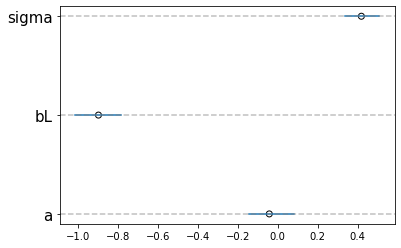

In [20]:
print(precis(samples4))
plot_intervals(samples4, 0.89)

### Code 6.10
Now put both $F$ and $L$ as predictiors in the same model

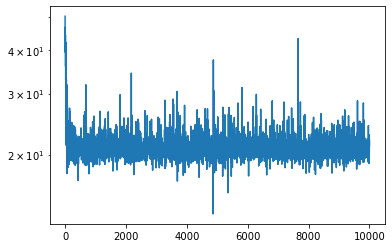

In [21]:
class M6_5(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 0.2))
        bF = pyro.sample("bF", Normal(0., 0.5))
        bL = pyro.sample("bL", Normal(0., 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", a + bF*self.F + bL*self.L)
        pyro.sample("K", Normal(mu, sigma), obs=self.K)
        
m6_5 = M6_5(df)
loss = m6_5.train(10000)
plt.plot(loss); plt.yscale("log"); plt.show()

            mean     stddev       5.5%     94.5%
a      0.0400406  0.0689881 -0.0699361   0.14885
bF      0.262973   0.189784 -0.0469815  0.571535
bL     -0.683469   0.171695  -0.960565 -0.410502
sigma   0.425347  0.0586953   0.336679  0.522981


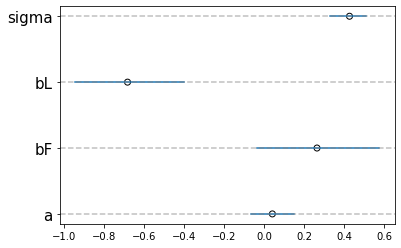

In [22]:
samples = sample_posterior(m6_5, 1000, ("a", "bL", "bF", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

### Code 6.11
Make a pairs plot of the variables in this model. You can see that $F$ and $L$ are very negatively correlated. The author's hypothesis is that there is some latent, unobserved variable which causally influences both $F$ and $L$. It would be better if we could simply regress $K$ on this latent, but we do not know it!

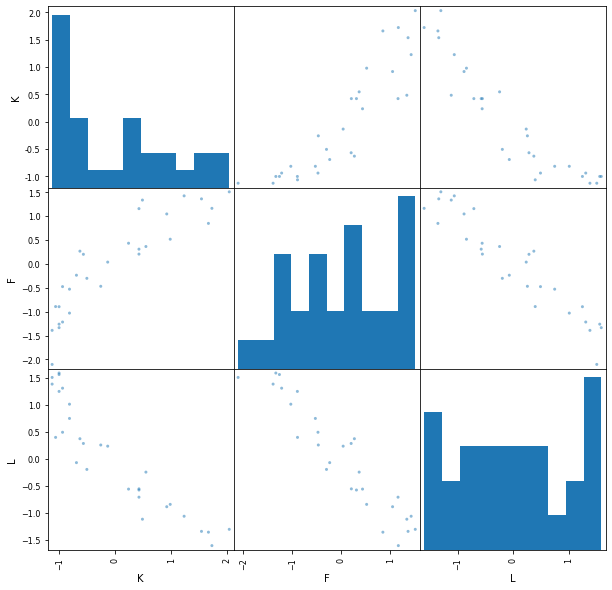

In [23]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))
plt.show()

An example of a causal diagram in which $F$ and $L$ are influenced by some (unobserved) variable $D$.

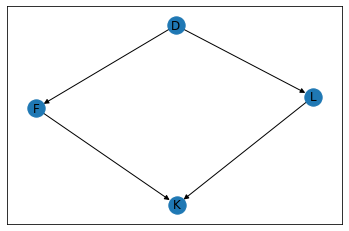

In [24]:
G = nx.DiGraph((("D", "F"), ("D", "L"), ("L", "K"), ("F", "K")))
nx.draw_networkx(G)

### Code 6.12
Simulate the growth of some plants subjected to an anti-fungal treatment, then analyze the effect of including the presence of fungus (a "post-treatment" effect)

In [25]:
N = 100
h0 = 2*np.random.randn(N) + 10 # heights
treatment = np.random.choice((0, 1), N)
fungus = st.binom(n=1, p=(0.5-0.4*treatment)).rvs(N)
h1 = h0 + (5 - 3*fungus) + np.random.randn(N)
d = pd.DataFrame([h0, h1, treatment, fungus], index=["h0", "h1", "treatment", "fungus"]).T
precis({k: d[k].values for k in d.columns})

,mean,stddev,5.5%,94.5%
h0,10.0659,2.13473,7.11285,13.5257
h1,14.399,2.81647,9.99928,18.9436
treatment,0.52,0.4996,0,1
fungus,0.22,0.414246,0,1


### Code 6.14 - 6.15
Let's do a simple regression using just the initial height as a predictor, and trying to infer the ratio between final/initial heights: $p = h_1/h_0$, which will be given a lognormal prior.

In [26]:
class M6_6(RegressionBase):
    def __call__(self):
        p = pyro.sample("p", LogNormal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = pyro.deterministic("mu", self.h0 * p)
        pyro.sample("h1", Normal(mu, sigma), obs=self.h1)

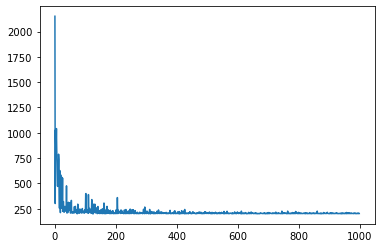

In [27]:
m6_6 = M6_6(d[["h1", "h0"]])
loss = m6_6.train(1000)
plt.plot(loss); plt.show()

In [28]:
samples = sample_posterior(m6_6, 1000, ("p", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
p,1.41362,0.0352826,1.35932,1.47333
sigma,1.77064,0.131673,1.56864,1.98302


### Code 6.16
Do regression but using `treatment` and `fugus` as categorical predictors

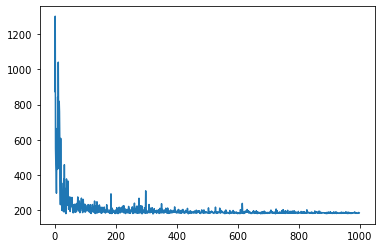

In [29]:
class M6_7(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        bf = pyro.sample("bf", Normal(0, 0.5))
        p = pyro.deterministic("p", a + bt * self.treatment + bf * self.fungus)
        mu = pyro.deterministic("mu", self.h0 * p)
        sigma = pyro.sample("sigma", Exponential(1.))
        pyro.sample("h1", Normal(mu, sigma), obs=self.h1)

m6_7 = M6_7(d, categoricals=["treatment", "fungus"])
loss = m6_7.train(1000)
plt.plot(loss); plt.show()

In [30]:
samples = sample_posterior(m6_7, 1000, ("a", "bt", "bf", "sigma"))
precis(samples)

,mean,stddev,5.5%,94.5%
a,1.48706,0.0453216,1.41644,1.5583
bt,-0.0226021,0.0558233,-0.108365,0.0717007
bf,-0.255722,0.0579958,-0.348897,-0.162173
sigma,1.39821,0.103894,1.24337,1.57103


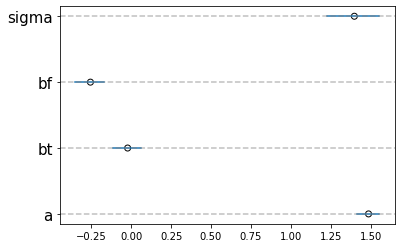

In [31]:
plot_intervals(samples, 0.89)

### Code 6.17-6.19

Interesting how the `treatment` appears to have very little effect; the value of `bt` is very close to zero and the distribution is pretty tight. Schematically, our data generating model implies the following causal diagram:

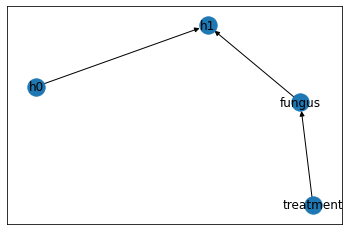

In [32]:
G = nx.DiGraph((("treatment", "fungus"), ("h0", "h1"), ("fungus", "h1")))
nx.draw_networkx(G)

Note how `treatment` is "blocked" by `fungus`... if we know `fungus`, there's basically no point in knowing `treatment`. In fact, let's take a look at the conditional/marginal independencies of this DAG:

In [33]:
conditional_independencies(G)

[('treatment', 'h0', 'fungus'),
 ('treatment', 'h0', 'h1'),
 ('treatment', 'h1', 'fungus'),
 ('fungus', 'h0', 'treatment')]

In [34]:
marginal_independencies(G)

[('treatment', 'h0', {}), ('fungus', 'h0', {})]

Some of these are pretty obvious, like both `treatment` and `fungus` are marginally independent of `h0`... there is no way the initial height of the plant influences the treatment/fungus or vice versa (unless there was some preferential application of treatment to taller/shorter plants, which there isn't). However, we can see that there is one that says that `treatment`/`h1` are independent given `fungus`. Basically saying that there is no way `treatment` is not useful as a predictor anymore given access to `fungus`. So what would the regression look like if we simply removed `fungus` as a predictor?

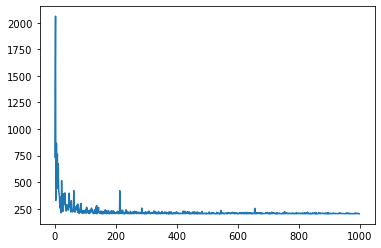

In [35]:
class M6_8(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        p = pyro.deterministic("p", a + bt * self.treatment)
        mu = pyro.deterministic("mu", self.h0 * p)
        sigma = pyro.sample("sigma", Exponential(1.))
        pyro.sample("h1", Normal(mu, sigma), obs=self.h1)
        
m6_8 = M6_8(d, categoricals=["treatment", "fungus"])
loss = m6_8.train(1000)
plt.plot(loss); plt.show()

            mean     stddev       5.5%     94.5%
a        1.40349   0.046594    1.33206    1.4795
bt     0.0516388  0.0642489 -0.0508912  0.156564
sigma    1.74122   0.146562    1.52222   1.98703


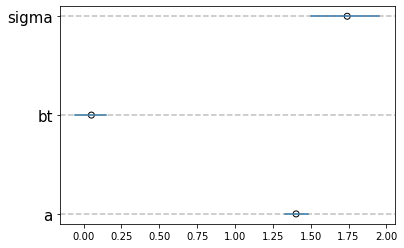

In [36]:
samples = sample_posterior(m6_8, 1000, ("a", "bt", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

Now we can see that `treatment` has a (small) nonzero effect on `h1` equivalent to increasing plant growth by about 10%.

### Code 6.20
We can see that the treatment DOES have an affect on the plant growth, but what if it turned out that the treatment/fugus were spurious predictors, and didn't acutally causally influence growth? This could be achieved if there was some unobserved confounding factor that influenced both `h1` and `fugus`, and `fungus` didn't actually influence it at all. Let's pretend that this unobserved node is "moisture", and draw the DAG for it:

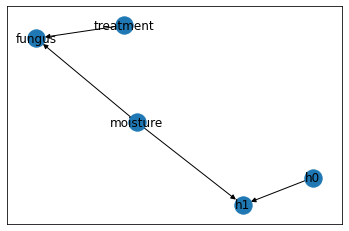

In [37]:
G = nx.DiGraph((("h0", "h1"), ("moisture", "h1"), ("treatment", "fungus"), ("moisture", "fungus")))
nx.draw_networkx(G)

Now let's re-generate the data using moisture $M$ as a confounding factor and run the analysis on the two models m6_7 and m6_8

In [38]:
N = 1000
h0 = 10 + 2*np.random.randn(N)
treatment = np.random.choice((0, 1), size=N)
M = st.bernoulli(p=0.5).rvs(N)
fungus = st.binom(n=1, p=(0.5-0.4*treatment + 0.4*M)).rvs(N)
h1 = h0 + (5 + 3*M) + np.random.randn(N)
d2 = pd.DataFrame([h0, h1, treatment, fungus], index=["h0", "h1", "treatment", "fungus"]).T
precis({k: d2[k].values for k in d2.columns})

,mean,stddev,5.5%,94.5%
h0,10.0063,1.98219,6.74678,13.1291
h1,16.543,2.70012,12.2379,20.8734
treatment,0.525,0.499375,0,1
fungus,0.49,0.4999,0,1


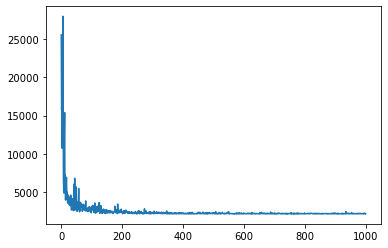

In [39]:
m6_7 = M6_7(d2, categoricals=["treatment", "fungus"])
loss = m6_7.train(1000)
plt.plot(loss); plt.show()

            mean     stddev       5.5%     94.5%
a        1.52788  0.0713025    1.41701   1.64106
bt     0.0586684  0.0660768 -0.0475698  0.168068
bf      0.147949  0.0643997  0.0479704  0.250428
sigma    2.23185   0.164555    1.98601   2.50724


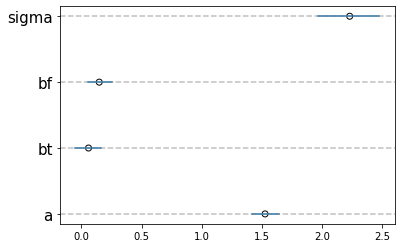

In [40]:
samples = sample_posterior(m6_7, 1000, ("a", "bt", "bf", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

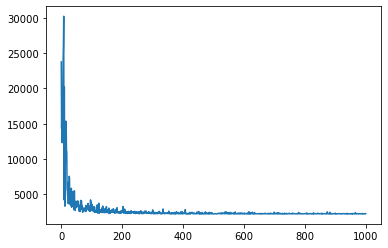

In [41]:
m6_8 = M6_8(d2, categoricals=["treatment", "fungus"])
loss = m6_8.train(1000)
plt.plot(loss); plt.show()

            mean     stddev       5.5%     94.5%
a        1.60964  0.0597477    1.51604   1.70562
bt     0.0178339  0.0664739 -0.0869308  0.127272
sigma    2.29616   0.160986    2.04363   2.55837


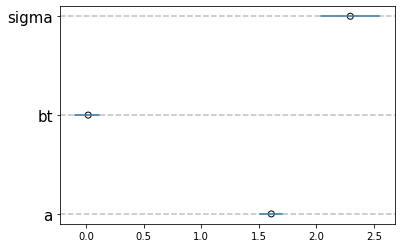

In [42]:
samples = sample_posterior(m6_8, 1000, ("a", "bt", "bf", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

### Code 6.21
Now we're going to look at "collider bias", where conditioning on the common descendent in a DAG (like node B in the graph A -> B <- C), causes a statistical association between A and C, even though there is no causal connection. We can create an example to demonstrate this using the following simulation:

1. Each year, 20 people are born with uniformly distributed happiness values
2. Each year, each person ages one year. Happiness does not change.
3. At age 18, individuals can become married. The odds of marriage are proportional to an individual's happiness.
4. Once married, an individual remains married.
5. After age 65, individuals leave the sample. (the author suggests "they move to Spain", but we know what he means...)

This simulation generates data according to the DAG $H \rightarrow M \leftarrow A$, where $H$ is happiness, $M$ is marriage, and $A$ is age. I'm not entirely sure what the parameters for the marriage probability etc. are, but will try my best.

In [43]:
def sim_happiness(N_years):
    people = deque()
    age = []
    married = []
    happiness = []
    # Update population statistics and take data every year
    for year in tqdm.notebook.tnrange(N_years):
        # 20 new people are born
        for i in range(20):
            h = 4*(i/19 - 0.5)
            person = dict(age=-1, married=False, happiness=h)
            people.append(person)
        # Discard people over 65 from the sample
        while people[0]["age"] > 65:
            people.popleft()
        # Update age/marriage
        for person in people:
            person["age"] += 1
            if (person["age"] >= 18) and (not person["married"]):
                p = 0.07*(person["happiness"] + 2)/4
                person["married"] = np.random.choice((True, False), p=(p, 1-p))
    # Collect data
    for person in people:
        age.append(person["age"])
        married.append(int(person["married"]))
        happiness.append(person["happiness"])
    # Put all data in dataframe
    df = pd.DataFrame(dict(age=age, married=married, happiness=happiness))
    return df

d = sim_happiness(100)
precis({k: d[k].values for k in d.columns})

,mean,stddev,5.5%,94.5%
age,33,19.3391,3,63
married,0.354478,0.478355,0,1
happiness,-4.0432e-17,1.21395,-1.78947,1.78947


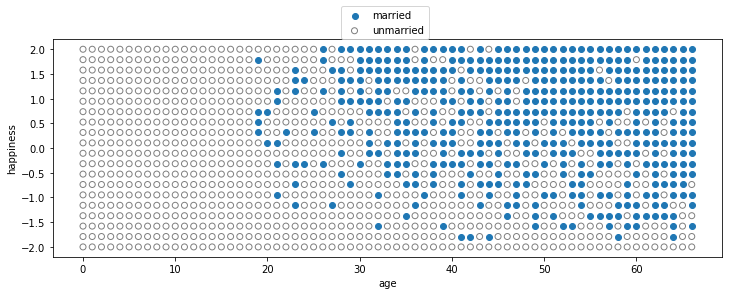

In [44]:
fig = plt.figure(figsize=(12, 4))
x = d["age"].values
y = d["happiness"].values
m = d["married"].astype(bool).values
plt.scatter(x[m], y[m], facecolor="C0", edgecolor="C0", label="married")
plt.scatter(x[~m], y[~m], facecolor="none", edgecolor="gray", label="unmarried")
plt.xlabel("age")
plt.ylabel("happiness")
plt.legend(loc=(0.43, 1))
plt.show()

### Code 6.22 - 6.23
Do a regression on this dataset using the model $\mu_i = \alpha_{\text{MID}[i]} + \beta_A A_i$

In [45]:
d2 = d[d["age"] > 17].copy()
d2["A"] = (d2["age"] - 18)/(65-18)

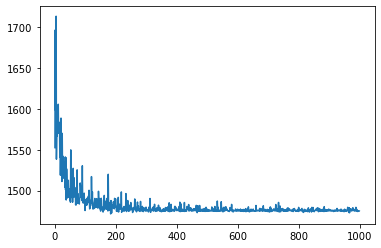

In [46]:
class M6_9(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.).expand([2]).to_event(0))
        bA = pyro.sample("bA", Normal(0., 2.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a[self.married] + bA*self.A
        pyro.sample("happiness", Normal(mu, sigma), obs=self.happiness)

m6_9 = M6_9(d2, categoricals=("married",))
loss = m6_9.train(1000)
plt.plot(loss); plt.show()

           mean     stddev      5.5%     94.5%
bA    -0.756399   0.132793 -0.967432 -0.541241
sigma   1.07106  0.0374397   1.01101   1.12876
a0    -0.220606  0.0684075 -0.330416 -0.106244
a1      1.01083  0.0845897  0.871423   1.15101


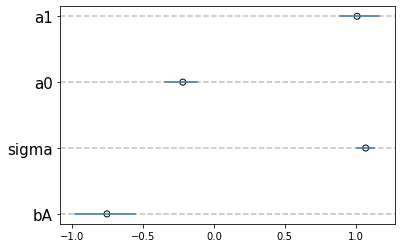

In [47]:
samples = sample_posterior(m6_9, 1000, ("a", "bA", "sigma"))
samples["a0"] = samples["a"][:,0]
samples["a1"] = samples["a"][:,1]
del samples["a"]
print(precis(samples))
plot_intervals(samples, 0.89)

In [48]:
precis(samples)

,mean,stddev,5.5%,94.5%
bA,-0.756399,0.132793,-0.967432,-0.541241
sigma,1.07106,0.0374397,1.01101,1.12876
a0,-0.220606,0.0684075,-0.330416,-0.106244
a1,1.01083,0.0845897,0.871423,1.15101


### Code 6.24
The above model is certain that age is negatively correlated with happiness, even though we know from our simulation that it isn't. Now, let's create a new model that doesn't take marriage status into account:

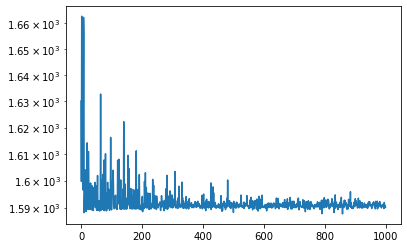

In [49]:
class M6_10(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.))
        bA = pyro.sample("bA", Normal(0., 2.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a + bA*self.A
        pyro.sample("happiness", Normal(mu, sigma), obs=self.happiness)
        
m6_10 = M6_10(d2[["A","happiness"]])
loss = m6_10.train(1000)
plt.plot(loss); plt.yscale("log"); plt.show()

              mean     stddev      5.5%     94.5%
a      0.000121688  0.0692414 -0.111807  0.108514
bA     -0.00955803    0.13569 -0.228792  0.203769
sigma       1.2033  0.0347656    1.1497   1.25692


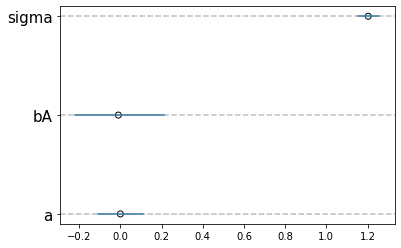

In [50]:
samples = sample_posterior(m6_10, 1000, ("a", "bA", "sigma"))
print(precis(samples))
plot_intervals(samples, 0.89)

Now it looks like $\beta_A$ is consistent with zero, so that there is no relationship between age and happiness

### Code 6.25-6.27
Assume we are studying the effect of grandparents $G$ and parents $P$ on the educational achievments of their children $C$. Presumably, $G$ also influences $P$, so we have a DAG like:

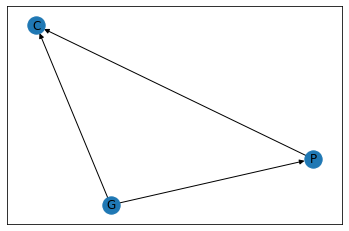

In [51]:
G = nx.DiGraph((("G", "P"), ("P","C"), ("G", "C")))
nx.draw_networkx(G)

But what if there is an unobserved factor $U$ that affects both $P$ and $C$? (Like maybe the neighborhood the parents/children live in)

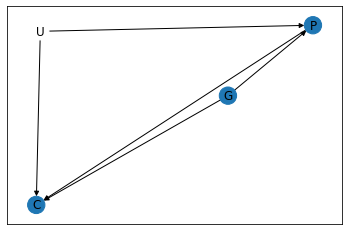

In [52]:
G.add_node("U", color="white")
G.add_edge("U", "C")
G.add_edge("U", "P")
col = ["white" if n == "U" else "C0" for n in G.nodes]
nx.draw_networkx(G, node_color=col)

If we condition on $P$, then it will bias inference about $G \rightarrow C$, even if $U$ is never observed. Let's generate some example data to show this effect:

In [53]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

U = 2*st.bernoulli(p=0.5).rvs(N) - 1
G = np.random.randn(N)
P = b_GP*G + b_U*U + np.random.randn(N)
C = b_PC*P + b_GC*G + b_U*U + np.random.randn(N)
d = pd.DataFrame(dict(C=C, P=P, G=G, U=U))

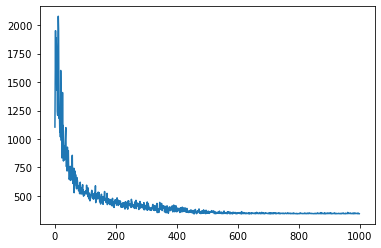

In [54]:
class M6_11(RegressionBase):
    def __call__(self):
        sigma = pyro.sample("sigma", Exponential(1.))
        a = pyro.sample("a", Normal(0., 1.))
        b_PC = pyro.sample("b_PC", Normal(0., 1.))
        b_GC = pyro.sample("b_GC", Normal(0., 1.))
        mu = a + b_PC*self.P + b_GC*self.G
        pyro.sample("C", Normal(mu, sigma), obs=self.C)
        
m6_11 = M6_11(d[["P", "C", "G"]])
loss = m6_11.train(1000)
plt.plot(loss); plt.show()

            mean     stddev      5.5%     94.5%
sigma    1.30648  0.0997806   1.15088   1.46807
a     -0.0199111  0.0874506 -0.153746  0.121347
b_PC     1.76798  0.0660739   1.66226    1.8759
b_GC   -0.733346   0.119253 -0.907715 -0.552933


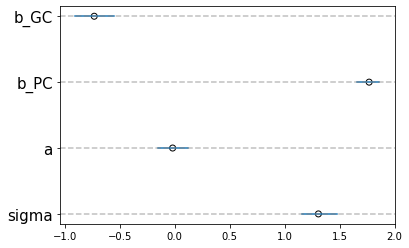

In [55]:
samples = sample_posterior(m6_11, 1000, ("sigma", "a", "b_PC", "b_GC"))
print(precis(samples))
plot_intervals(samples, 0.89)

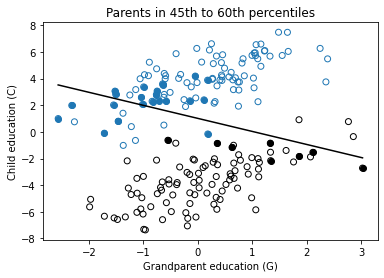

In [56]:
# Plot the unconditional distributions of G and C
mask1 = d["U"] == 1
plt.scatter(d.loc[mask1, "G"], d.loc[mask1, "C"], facecolor="none", edgecolor="C0")
plt.scatter(d.loc[~mask1, "G"], d.loc[~mask1, "C"], facecolor="none", color="black")
# Plot the distributions of G and C conditional on P being between the 45-60th percentiles
mask2 = d["P"].between(*np.quantile(d["P"], (0.45, 0.60)))
plt.scatter(d.loc[mask1 & mask2, "G"], d.loc[mask1 & mask2, "C"], color="C0")
plt.scatter(d.loc[(~mask1) & mask2, "G"], d.loc[(~mask1) & mask2, "C"], color="black")
# Draw regression line through the conditional distribution
x = d.loc[mask2, "G"].values
y = d.loc[mask2, "C"].values
m, b, _, _, _ = st.linregress(x, y)
x = np.linspace(d["G"].min(), d["G"].max())
y = m*x + b
plt.plot(x, y, color="black")
plt.xlabel("Grandparent education (G)")
plt.ylabel("Child education (C)")
plt.title("Parents in 45th to 60th percentiles")
plt.show()

### Code 6.28
The only way we can alleviate the above problem is by controlling for $U$:

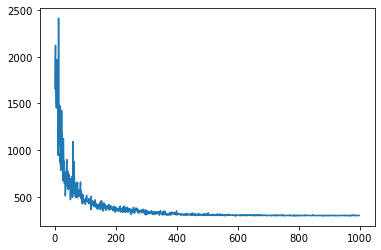

In [57]:
class M6_12(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.))
        b_PC = pyro.sample("b_PC", Normal(0., 1.))
        b_GC = pyro.sample("b_GC", Normal(0., 1.))
        b_U = pyro.sample("b_U", Normal(0., 1.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a + b_PC*self.P + b_GC*self.G + b_U*self.U
        pyro.sample("C", Normal(mu, sigma), obs=self.C)
        
m6_12 = M6_12(d)
loss = m6_12.train(1000)
plt.plot(loss); plt.show()

            mean     stddev      5.5%      94.5%
a     -0.0372712  0.0641043 -0.141221  0.0638744
b_PC     1.07913  0.0831582  0.948792    1.21173
b_GC  -0.0309744   0.116894 -0.219048   0.155677
b_U      1.65237   0.180044    1.3671    1.93896
sigma    1.01679  0.0709954  0.908092    1.13543


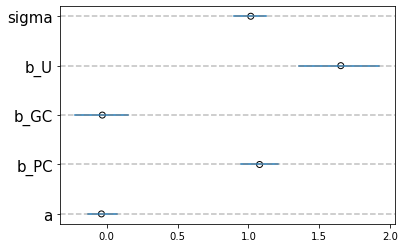

In [58]:
samples = sample_posterior(m6_12, 5000)
del samples["C"]
print(precis(samples))
plot_intervals(samples, 0.89)

### Code 6.29 - 6.30
Let's consider the following DAG (where $U$ is unobserved):

c:\users\ecotner\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


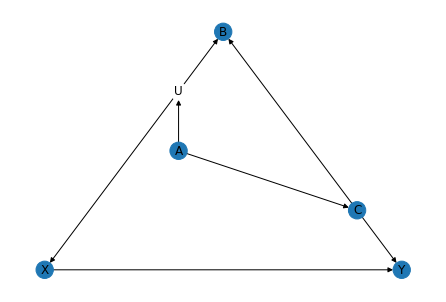

In [59]:
G = nx.DiGraph((("X", "Y"), ("U", "X"), ("U","B"), ("A","U"), ("A", "C"), ("C", "B"), ("C", "Y")))
G.nodes["U"]["color"] = "white"
color = [v.get("color", "C0") for k, v in G.nodes.items()]
nx.draw_planar(G, with_labels=True, node_color=color)

We want to infer the causal effect of $X$ on $Y$, but we can see that there are some counfounding paths (backdoors) that could prevent inference. Specifically, there are two paths (1) $X \leftarrow U \leftarrow A \rightarrow C \rightarrow Y$ and (2) $X \leftarrow U \rightarrow B \leftarrow C \rightarrow Y$. We can see that (2) is actually already blocked because of the collider on $B$, but (1) is currently unblocked. This means that we would need to condition on either $B$ or $C$ to close off the backdoor. Conditioning on $C$ is probably better since it is closer to $Y$ and so we wouldn't have to worry about the effect of uncertainty in $B$ influencing things.

Now consider the waffle house example from the very beginning of the chapter. The DAG representing the causal influences here is

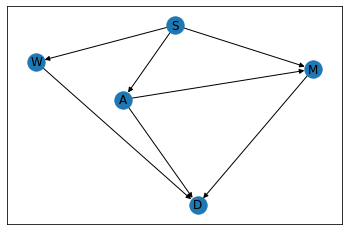

In [60]:
G = nx.DiGraph((("S", "W"), ("W", "D"), ("S", "M"), ("M", "D"), ("S", "A"), ("A", "M"), ("A", "D")))
nx.draw_networkx(G, with_labels=True)

In this graph, $S$ is whether or not a state is "southern", $A$ is median age at marriage, $W$ is the number of Waffle Houses, $M$ is the marriage rate, and $D$ is the divorce rate. This graph assumes that southern states have lower ages of marriage ($S \rightarrow A$), higher rates of marriage both directly ($S \rightarrow M$), and mediated through age of marriage ($S \rightarrow A \rightarrow M$), as well as more Waffle Houses ($S \rightarrow W$). Age of marriage and marriage rate both influence divorce. There are three open backdoor paths from $W$ to $D$:
$$
W \leftarrow S \rightarrow A \rightarrow D \\
W \leftarrow S \rightarrow A \rightarrow M \rightarrow D \\
W \leftarrow S \rightarrow M \rightarrow D
$$
There is one other backdoor path ($W \leftarrow S \rightarrow M \leftarrow A \rightarrow D$), but it is already closed because of the collider on $M$. So in order to close these backdoor paths, our options are to condition on either $S$ or $\{A, M\}$ (conditioning on $A$ by itself is not enough, because the $W \leftarrow S \rightarrow M \rightarrow D$ path is still open). It is probably best to just condition on $S$ because it will keep the model simpler. Why add two predictors when you only need one?

### Code 6.31
Is there any way we can test whether this DAG is correct? Well... no, because there could always be unobserved confounds that we haven't thought of. But we can test and see whether the DAG is _incorrect_ using conditional independencies implied by the graph.

In [61]:
conditional_independencies(G)

[('W', 'M', 'S'), ('W', 'A', 'S')]